In [2]:
import os.path

from u2net import U2NET
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from skimage import transform
from umap import UMAP
import datetime
import os
from skimage import io
import csv
from skimage.metrics import structural_similarity as ssim


from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
all_images_rgb = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        tf_image = tf.expand_dims(image_gray / 255, 2)
    #    tf_rgb = tf.image.grayscale_to_rgb(tf_image)
        tf_preproc = tf.image.resize(tf_image, (1024, 1024))
        all_images_rgb.append(tf_preproc)

all_images_rgb = np.array(all_images_rgb)

In [4]:

image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)
# net.built=True
# net.load_weights('data/saved_models/u2net_loss=0.0089.h5')

model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')

In [8]:

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE_PER_REPLICA = 1
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

with strategy.scope():
    image_shape = (1024, 1024, 1)
    inputs = tf.keras.Input(shape=image_shape)
    net = U2NET(1)
    out = net(inputs)
    net.built=True
    net.load_weights('data/saved_models/u2netP_loss=0.0027.h5')

    model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [4]:
class SaveCallback(tf.keras.callbacks.Callback):

    def __init__(self,test_images,save_dir,n_samples,net):
        super().__init__()
        self.images=test_images
        self.safe_dir=save_dir
        self.n_samples=n_samples
        self.net=net

        if not os.path.exists(save_dir):
            os.makedirs(self.safe_dir)


    def on_epoch_end(self, epoch, logs=None):
        indeces=np.random.randint(0,len(self.images),size=self.n_samples)
        for i in indeces:
            predict=self.net(tf.expand_dims(self.images[i],axis=0))[0][0]
            original=self.images[i]
            concat=np.concatenate([predict.numpy(),original],axis=1)
            tf.keras.preprocessing.image.save_img(f'{self.safe_dir}epoch={epoch}_index={i}.png',concat*255)






In [5]:
x_train, x_test, y_train, y_test = train_test_split(  all_images_rgb[:100],all_images_rgb[:100], test_size=0.2 )
name=f'u2net_{datetime.datetime.now().date()}'
log_dir=f'data/logs/{name}_tensorboard/'
checkpoint_filepath = f'data/logs/{name}_checkpoint/checkpoints/'
csv_log_path= f'data/logs/train_csv/'
csv_log_filepath= csv_log_path+f'{name}.csv'
images_save_dir=f'data/logs/{name}_val_images/'

if not os.path.exists(csv_log_filepath):
    os.makedirs(csv_log_filepath)

if not os.path.exists(csv_log_filepath):
    with open(csv_log_filepath,'wb') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)


In [9]:
optim=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.1, epsilon=1e-07, centered=True)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

csv_logger = tf.keras.callbacks.CSVLogger(csv_log_filepath)

n_samples=3

save_callback=SaveCallback(x_test,images_save_dir,n_samples,net)


model.compile(optimizer=optim, loss='mse', metrics=['MAE'])
history=model.fit(x_train, y_train,
                  epochs=50,
                  batch_size=2,
                  shuffle=True,
                  validation_data=(x_test, x_test),
                  callbacks=[tensorboard_callback,
                             model_checkpoint_callback,
                             early_stop_callback,
                             csv_logger,
                             save_callback])

Epoch 1/50
40/40 [==============================] - 36s 676ms/step - loss: 0.0095 - MAE: 0.0621 - val_loss: 0.1074 - val_MAE: 0.2882
Epoch 2/50
40/40 [==============================] - 25s 614ms/step - loss: 0.0088 - MAE: 0.0592 - val_loss: 0.0206 - val_MAE: 0.0948
Epoch 3/50
27/40 [===================>..........] - ETA: 7s - loss: 0.0085 - MAE: 0.0582

KeyboardInterrupt: 

In [34]:
loss=0.0089
net.save_weights(f'u2net_loss={loss}.h5')

In [6]:
image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)

model = tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')
model.built = True
model.load_weights('data/logs/u2net_2021-11-19_checkpoint/checkpoints/')


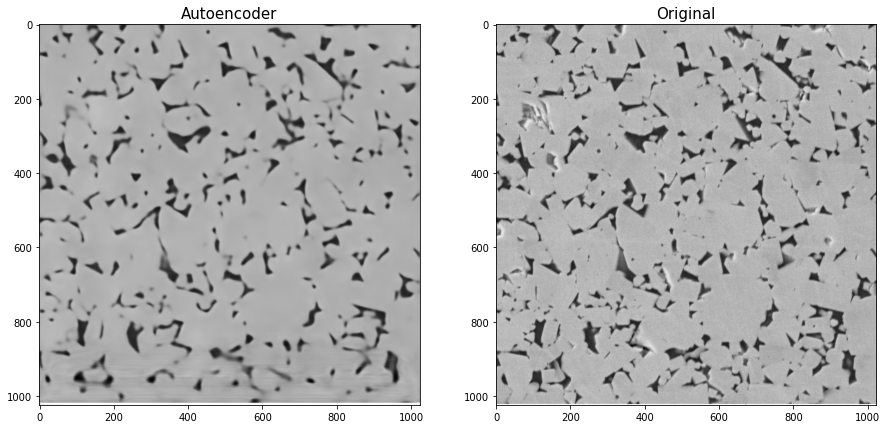

In [7]:
#predict=model.predict(tf.expand_dims(all_images_rgb[0],axis=0))[0]
n=1

predict=net(tf.expand_dims(x_test[n],axis=0))[0][0]

original=x_test[n]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(predict,cmap='gray')
ax1.set_title('Autoencoder',fontsize=15)

ax2.imshow(original,cmap='gray')
ax2.set_title('Original',fontsize=15)
#plt.savefig(f'autoencoder{name}.png')
plt.show()

In [14]:
net(tf.expand_dims(all_images_rgb[0],axis=0))[1][0].numpy().shape

(32, 32, 512)

## Visualization

In [8]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
images_embs = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        resized = transform.resize(image_gray, (1024, 1024,1))
        emb=net(tf.expand_dims(resized/255,axis=0))[1][0].numpy().flatten()
        images_embs.append(emb)

In [9]:
umap_1d=UMAP(n_components=1)
umaped_vct_1d=umap_1d.fit_transform(images_embs)


KeyboardInterrupt: 

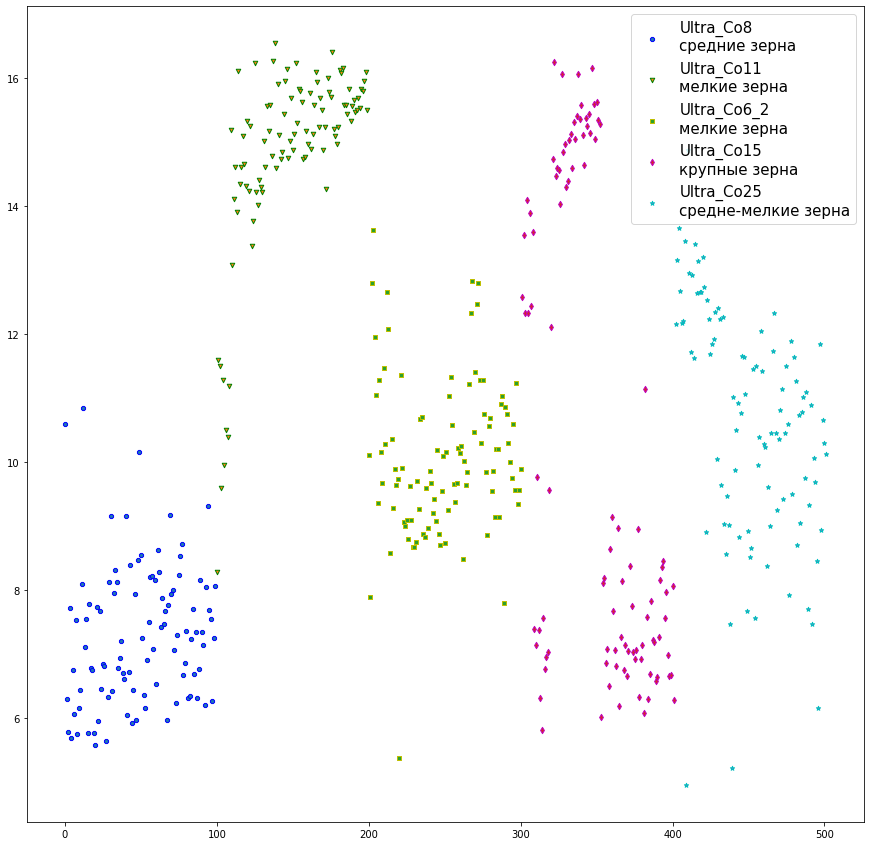

In [15]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
size=20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors=['b','g','y','m','c']
markers=['8','v','s','d','*',]

for i,images_list in enumerate(all_images):
    start=0
    for j in range(i):
        start+=len(all_images[j])
    end=start+len(images_list)

    ax.scatter(np.arange(start,end),umaped_vct_1d[start:end],edgecolor=colors[i], s=size,marker=markers[i])

ax.legend(names,fontsize=15)
#plt.savefig(f'embs_space_loss={loss}.png')
plt.show()

In [9]:
umap_2d=UMAP()
umaped_vct_2d=umap_2d.fit_transform(images_embs)

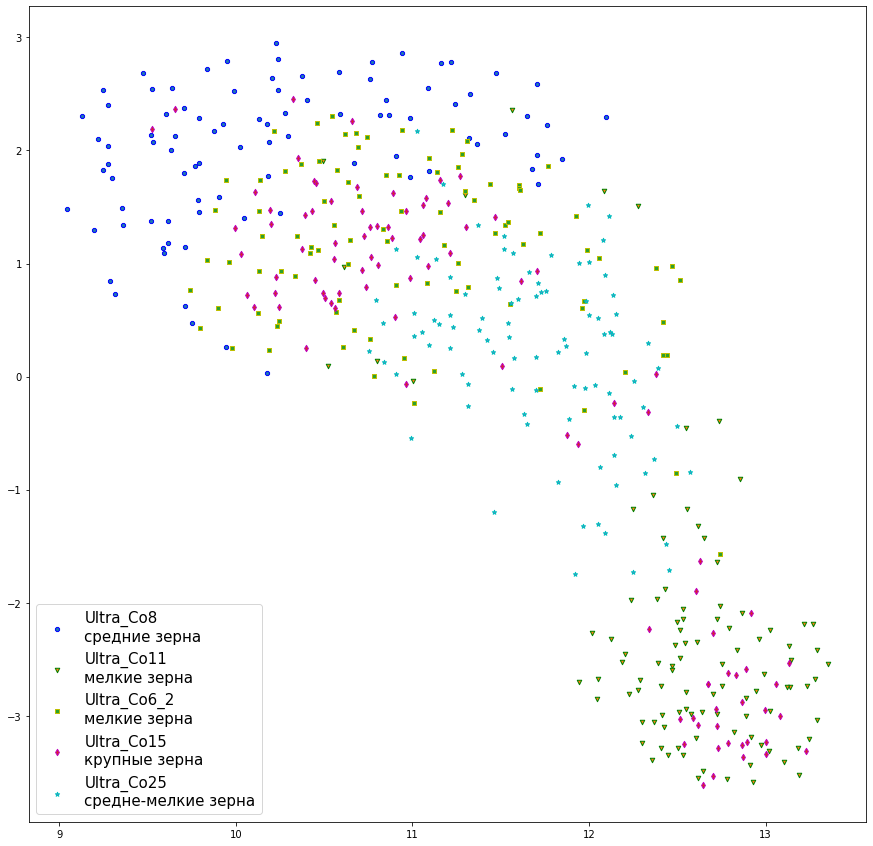

In [94]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
size=20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors=['b','g','y','m','c']
markers=['8','v','s','d','*',]

f_vects=[]

for i,images_list in enumerate(all_images):
    start=0
    for j in range(i):
        start+=len(all_images[j])
    end=start+len(images_list)
    f_vects.append([umaped_vct_2d[start:end, 0], umaped_vct_2d[start:end, 1]])
    ax.scatter(umaped_vct_2d[start:end, 0], umaped_vct_2d[start:end, 1],edgecolor=colors[i], s=size,marker=markers[i])

ax.legend(names,fontsize=15)
#plt.savefig(f'embs_space.png')
plt.show()

In [110]:
step=0.1
projection_axis=1
eps=0.2

def get_emb_distr(step,projection_axis,eps):
    axis_start=f_vects[0][projection_axis].min()
    axis_end=f_vects[0][projection_axis].max()

    for vects in f_vects:
        min_val=vects[projection_axis].min()
        max_val=vects[projection_axis].max()

        if min_val<axis_start:
            axis_start=min_val

        if max_val>axis_end:
            axis_end=max_val

    axis_vals=np.arange(axis_start,axis_end,step)
    points_distr=[]

    for i,vects in enumerate(f_vects):
        points_distr.append([])
        for axis_val in axis_vals:
            counter=0
            for point in vects[projection_axis]:
                if abs(point-axis_val)<=eps:
                    counter+=1
            points_distr[i].append(counter)

    for i,distr in enumerate(points_distr):
        points_distr[i]=np.array(points_distr[i])/sum(distr)

    return axis_vals,points_distr

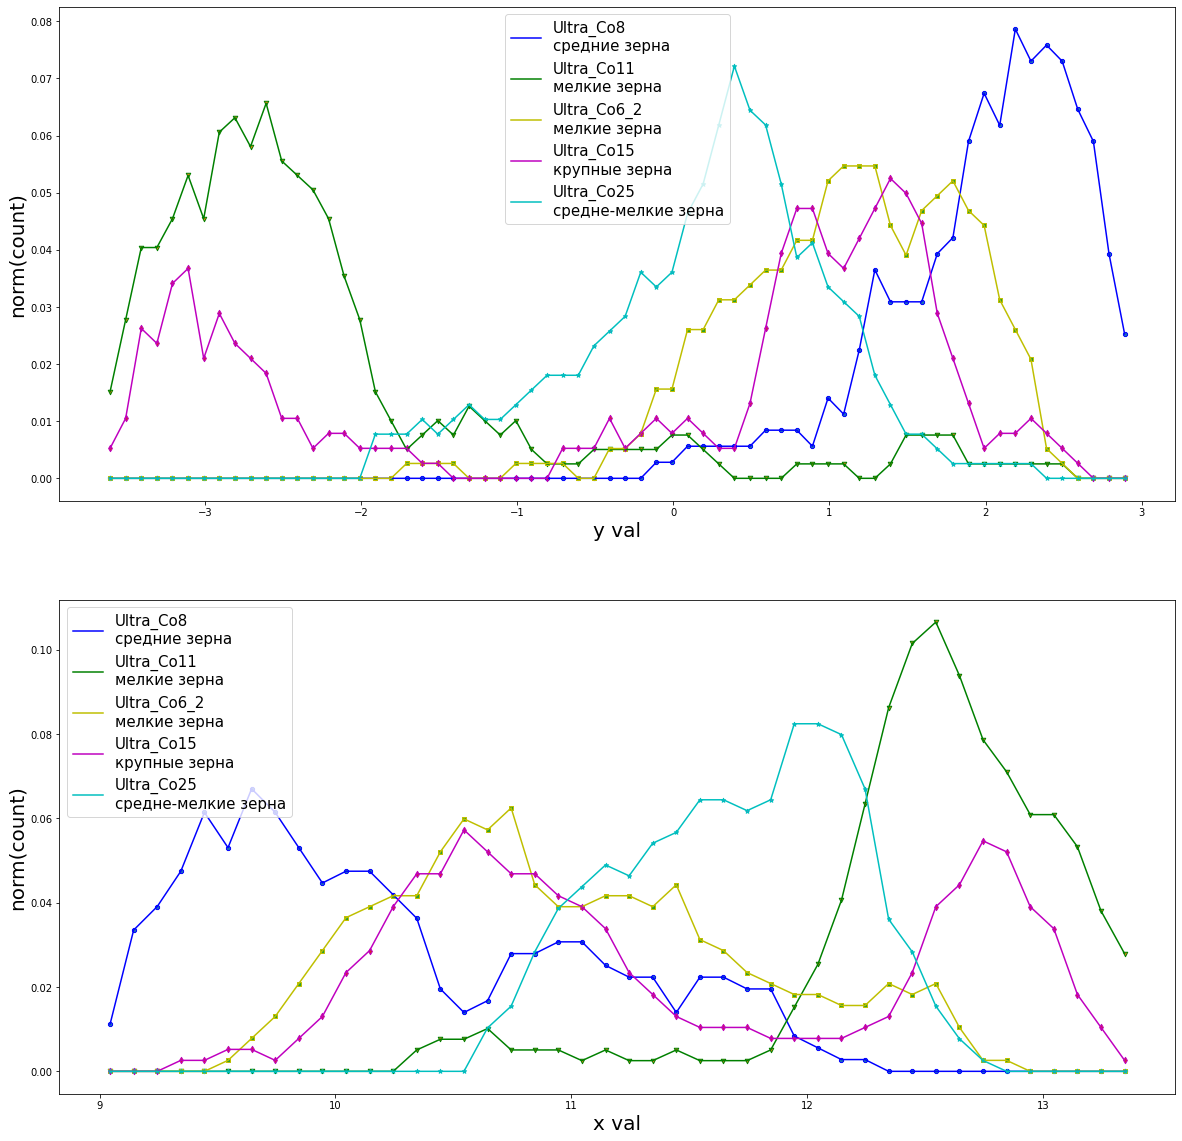

In [120]:
names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors=['b','g','y','m','c']
markers=['8','v','s','d','*',]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

x_axis_vals,x_points_distr=get_emb_distr(step,projection_axis=0,eps=eps)
y_axis_vals,y_points_distr=get_emb_distr(step,projection_axis=1,eps=eps)

for i in range(len(x_points_distr)):

    # y projection
    ax1.scatter(y_axis_vals,y_points_distr[i],edgecolor=colors[i], s=size,marker=markers[i])
    ax1.plot(y_axis_vals,y_points_distr[i],color=colors[i])
    ax1.legend(names,fontsize=15)
    ax1.set_xlabel('y val',fontsize=20)
    ax1.set_ylabel('norm(count)',fontsize=20)

    # x prjection
    ax2.scatter(x_axis_vals,x_points_distr[i],edgecolor=colors[i], s=size,marker=markers[i])
    ax2.plot(x_axis_vals,x_points_distr[i],color=colors[i])
    ax2.legend(names,fontsize=15)
    ax2.set_xlabel('x val',fontsize=20)
    ax2.set_ylabel('norm(count)',fontsize=20)


plt.savefig('embs projection')
plt.show()

(array([26.,  3.,  1.,  2.,  0.,  2.,  0.,  1.,  3.,  0.,  1.,  1.,  1.,
         1.,  2.]),
 array([ 0. ,  2.8,  5.6,  8.4, 11.2, 14. , 16.8, 19.6, 22.4, 25.2, 28. ,
        30.8, 33.6, 36.4, 39.2, 42. ]),
 <BarContainer object of 15 artists>)

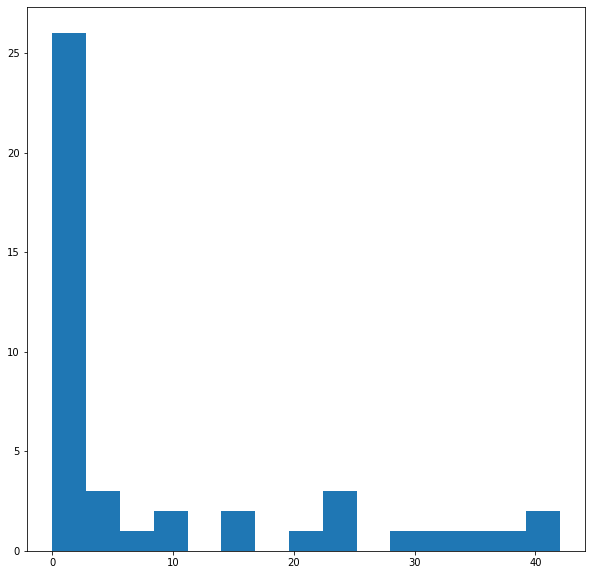

In [27]:
plt.figure(figsize=(10,10))
plt.hist(points_distr[1],bins=15)

In [13]:
umap_3d = UMAP(n_components=3)
umaped_vct_3d = umap_3d.fit_transform(images_embs)

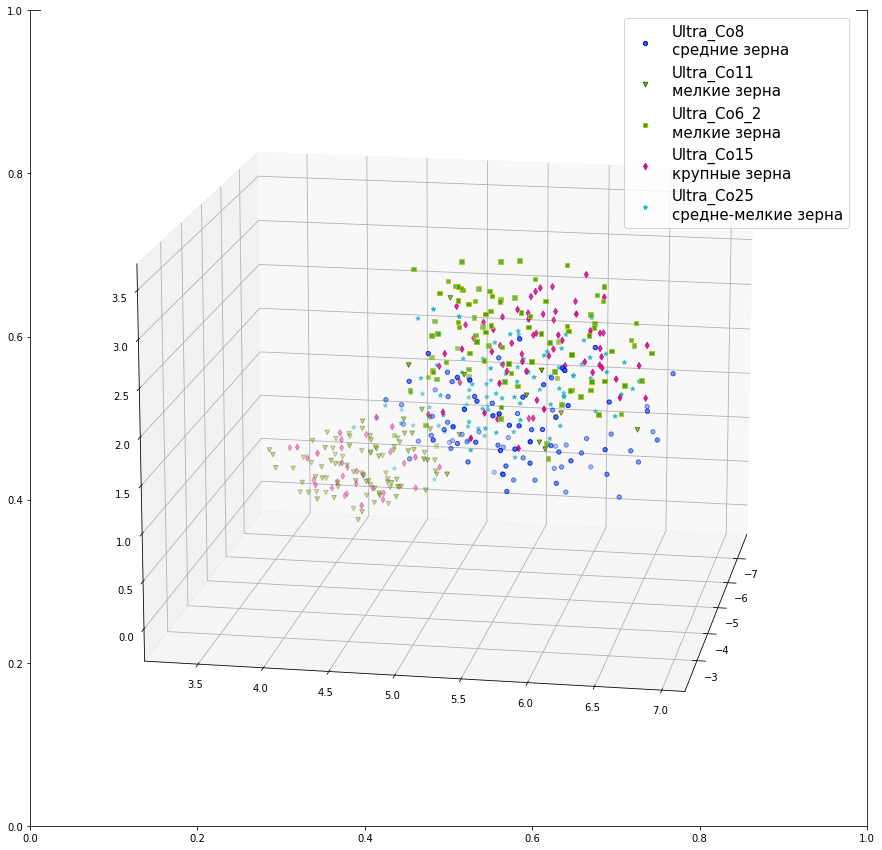

In [17]:
N = 15
fig, ax = plt.subplots(figsize=(N, N))
size = 20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

ax = plt.axes(projection='3d')
for i, images_list in enumerate(all_images):
    start = 0
    for j in range(i):
        start += len(all_images[j])
    end = start + len(images_list)

    ax.scatter3D(umaped_vct_3d[start:end, 0], umaped_vct_3d[start:end, 1],umaped_vct_3d[start:end, 2], edgecolor=colors[i], s=size, marker=markers[i])
  #  ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

ax.legend(names, fontsize=15)
#plt.savefig(f'embs_space_3d_loss={loss}.png')
ax.view_init(15,10)
plt.show()

In [63]:
N = 15
size = 20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

scatters=[]
for i, images_list in enumerate(all_images):
    start = 0
    for j in range(i):
        start += len(all_images[j])
    end = start + len(images_list)
    
    for point in umaped_vct_3d[start:end]:
        scatters.append([point[0],point[1],point[2],0.2,names[i],i+1]) 
        
   # ax.scatter3D(umaped_vct_3d[start:end, 0], umaped_vct_3d[start:end, 1],umaped_vct_3d[start:end, 2], edgecolor=colors[i], s=size, marker=markers[i])
  #  ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

    # creating a list of column names
column_values = ['x', 'y', 'z','width','name','class']
  
# creating the dataframe
df = pd.DataFrame(data = scatters,
                  columns = column_values)
    
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='name')
fig.show()